In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("ML470_S7_MallCustomers_Data_Concept.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
# helper functions for outlier assessment, treatment and scaling
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import pandas as pd

def assess_outliers(df, cols):
    """Return IQR-based outlier counts and plot boxplots for cols."""
    outlier_counts = {}
    fig, axes = plt.subplots(1, len(cols), figsize=(4*len(cols),4))
    if len(cols) == 1:
        axes = [axes]
    for ax, c in zip(axes, cols):
        Q1 = df[c].quantile(0.25)
        Q3 = df[c].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        mask = (df[c] < lower) | (df[c] > upper)
        outlier_counts[c] = int(mask.sum())
        sns.boxplot(y=df[c], ax=ax)
        ax.set_title(f"{c}\noutliers: {outlier_counts[c]}")
    plt.tight_layout()
    return outlier_counts

def treat_outliers(df, cols):
    """Cap values at IQR fences (winsorize-style) and return a new df copy."""
    df2 = df.copy()
    for c in cols:
        Q1 = df2[c].quantile(0.25)
        Q3 = df2[c].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df2[c] = df2[c].clip(lower=lower, upper=upper)
    return df2

def data_scale(df, cols):
    """Standard scale specified cols and return scaled array and scaler."""
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df[cols])
    scaled_df = pd.DataFrame(scaled, columns=cols, index=df.index)
    return scaled_df, scaler

In [6]:
# 1) Select numerical features and inspect head
cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
df[cols].head()

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


Outlier counts (before):
{'Age': 0, 'Annual Income (k$)': 2, 'Spending Score (1-100)': 0}


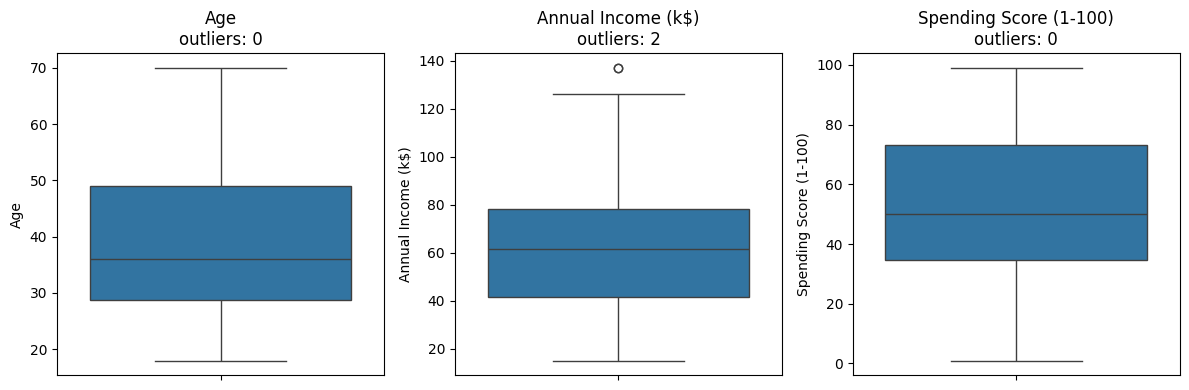

In [7]:
# 2) Assess outliers before treatment
print('Outlier counts (before):')
out_before = assess_outliers(df, cols)
print(out_before)

Outlier counts (after treatment):
{'Age': 0, 'Annual Income (k$)': 0, 'Spending Score (1-100)': 0}


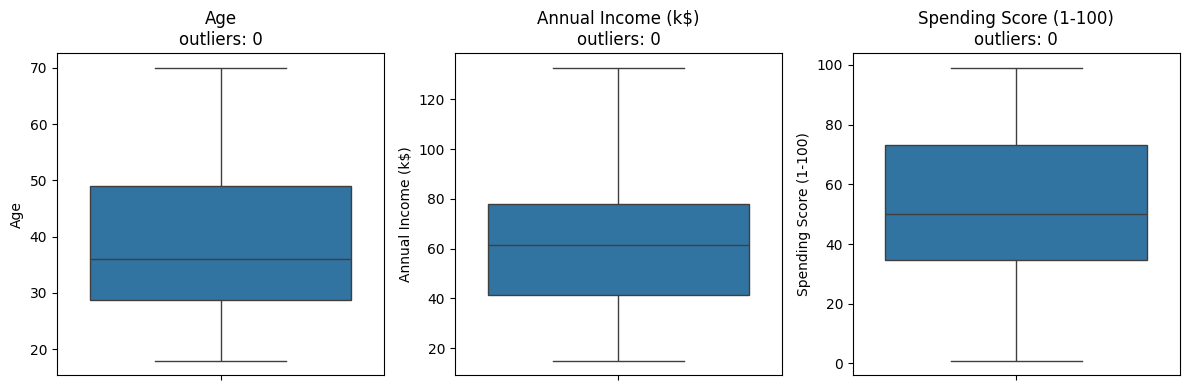

In [8]:
# 3) Treat outliers (cap to IQR fences) and re-assess
df_treated = treat_outliers(df, cols)
print('Outlier counts (after treatment):')
out_after = assess_outliers(df_treated, cols)
print(out_after)

In [9]:
# 4) Scale the treated numeric features for clustering
scaled_df, scaler = data_scale(df_treated, cols)
scaled_df.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.745429,-0.434801
1,-1.281035,-1.745429,1.195704
2,-1.352802,-1.707083,-1.715913
3,-1.137502,-1.707083,1.040418
4,-0.563369,-1.668737,-0.395980


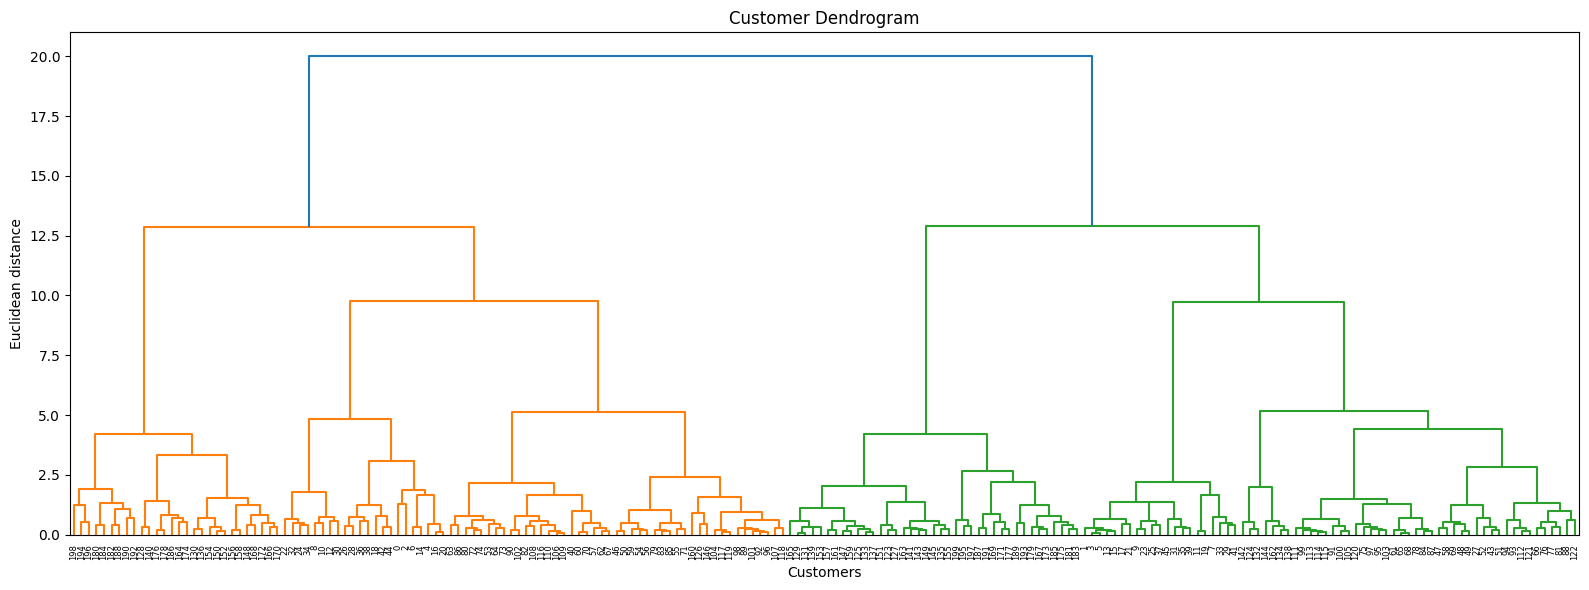

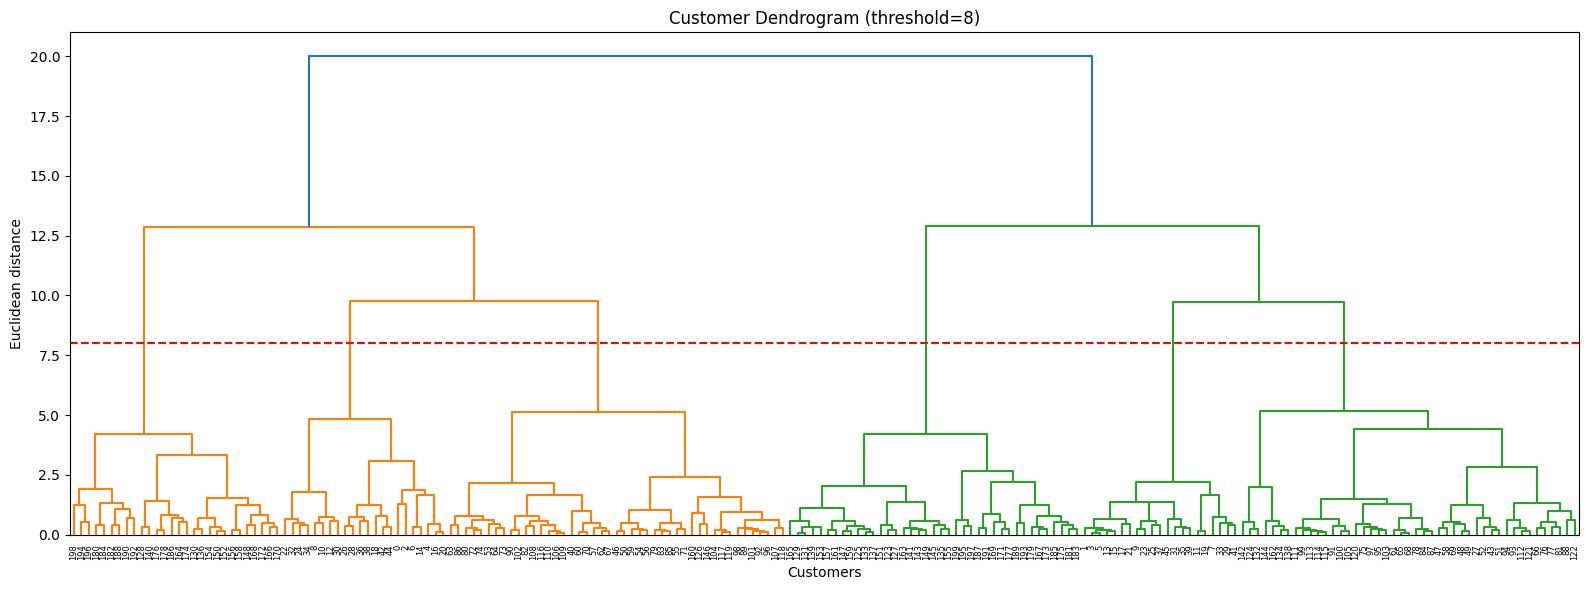

In [ ]:
# 5) Dendrograms using Ward linkage
X = scaled_df.values
Z = linkage(X, method='ward', metric='euclidean')

plt.figure(figsize=(16,6))
dendrogram(Z, labels=df_treated.index.astype(str).tolist(), leaf_rotation=90, leaf_font_size=6, color_threshold=None)
plt.title('Customer Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distance')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,6))
dendrogram(Z, labels=df_treated.index.astype(str).tolist(), leaf_rotation=90, leaf_font_size=6, color_threshold=None)
plt.hlines(8, xmin=0, xmax=plt.gca().get_xlim()[1], linestyles='dashed', colors='red')
plt.title('Customer Dendrogram (threshold=8)')
plt.xlabel('Customers')
plt.ylabel('Euclidean distance')
plt.tight_layout()
plt.show()

In [11]:
# 6) Save scaled data to be used for clustering algorithms
scaled_data_for_clustering = scaled_df.copy()
scaled_data_for_clustering.shape

(200, 3)

Notes:
- Outliers were assessed using IQR and capped to fences to preserve distribution shape.
- StandardScaler was applied so Age, Income and Spending Score are comparable for distance-based clustering.
- Two dendrograms were produced: plain and with a threshold line at distance=8 to help estimate cluster count.